In [33]:
import numpy as np 
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import utils as np_utils
from sklearn.model_selection import train_test_split
from EEGModels import EEGNet, DeepConvNet
from htnet_model import htnet

In [34]:
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
path=os.path.join("..","epoched_data/bci3")
data=np.load(os.path.join(path,"bci3epochs.npz"))
X=data['X']
y=data['y']
X_test=data['X_test']
y_test=data['y_test']

In [36]:
X.shape, y.shape

((834, 64, 1000), (834,))

In [37]:
X_train, X_validate, y_train, y_validate=train_test_split(X,y,test_size=0.2,random_state=42)

In [38]:
kernels, chans, samples = 1, 64, 1000

y_train      = np_utils.to_categorical((y_train+1)/2)
y_validate   = np_utils.to_categorical((y_validate+1)/2)
y_test       = np_utils.to_categorical((y_test+1)/2)
y            = np_utils.to_categorical((y+1)/2)

X            =X.reshape(X.shape[0],kernels,chans, samples)
X_train      = X_train.reshape(X_train.shape[0],kernels, chans, samples)
X_validate   = X_validate.reshape(X_validate.shape[0],kernels, chans, samples)
X_test       = X_test.reshape(X_test.shape[0], kernels, chans, samples)

In [39]:
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
print(K.image_data_format())

channels_first


In [40]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
# model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
# model= DeepConvNet(nb_classes=2, Chans = chans, Samples = samples,dropoutRate = 0.3)
model = htnet(useHilbert=True,nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 512,kernLength_sep=32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')

# compile the model and set the optimizers
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3,verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
checkpointer = ModelCheckpoint(filepath='checkpoint.h5', verbose=1,save_best_only=True)

fittedModel = model.fit(X_train, y_train, batch_size =2, epochs = 100, verbose = 2, validation_data=(X_validate, y_validate),callbacks=[reduce_lr,checkpointer])

Epoch 1/100
334/334 - 15s - loss: 0.7338 - accuracy: 0.4993 - val_loss: 0.6948 - val_accuracy: 0.5269

Epoch 00001: val_loss improved from inf to 0.69483, saving model to checkpoint.h5
Epoch 2/100
334/334 - 14s - loss: 0.6985 - accuracy: 0.5322 - val_loss: 0.6816 - val_accuracy: 0.6048

Epoch 00002: val_loss improved from 0.69483 to 0.68160, saving model to checkpoint.h5
Epoch 3/100
334/334 - 14s - loss: 0.6751 - accuracy: 0.6057 - val_loss: 0.7786 - val_accuracy: 0.4850

Epoch 00003: val_loss did not improve from 0.68160
Epoch 4/100
334/334 - 14s - loss: 0.6848 - accuracy: 0.5562 - val_loss: 0.6420 - val_accuracy: 0.6347

Epoch 00004: val_loss improved from 0.68160 to 0.64204, saving model to checkpoint.h5
Epoch 5/100
334/334 - 14s - loss: 0.6612 - accuracy: 0.5907 - val_loss: 0.6248 - val_accuracy: 0.6707

Epoch 00005: val_loss improved from 0.64204 to 0.62480, saving model to checkpoint.h5
Epoch 6/100
334/334 - 14s - loss: 0.6510 - accuracy: 0.6417 - val_loss: 0.6141 - val_accuracy:

In [22]:
model.load_weights('checkpoint.h5')
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(accuracy)

0.47999998927116394


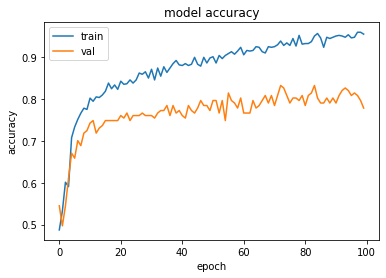

In [20]:
plt.figure(0)
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

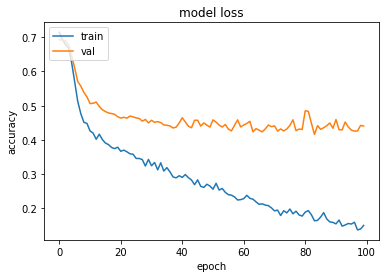

In [21]:
plt.figure(1)
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()